# Stroma Vision Machine Learning Engineer Technical Interview

**Çalışmanın amacı:** Video üzerinde düşen somun ile cıvataları yüksek doğrulukla ve hızla tespit etmek ve takip etmek.

**Gereklilikler:** 

In [ ]:
cd Stroma_Vision

In [ ]:
!pip install -r requirements.txt

**Ortam:**
```    
İşlemci: i7-11370H
Ekran Kartı: Nvidia GeForce RTX 3050 Ti - 4 GB
Ram: 16 GB
```
```
Windows 10
Cuda 11.6
Pytorch 1.8.1+cu111
```
```
(DeepStream için)
Ubuntu 20.04
GStreamer 1.16.3
NVIDIA driver 525.85.12
CUDA 11.8
TensorRT 8.5.2.2
```

Not: Projeyi çalıştırmada herhangi bir sorun çıkarsa yereldeki düzenlenmiş dosyaları kullanarak tekrar deneyiniz.

İşaretlemelerimiz COCO veri kümesi formatında olduğu ve model olarak YOLO kullanacağımız için verileri uygun formata getirmeliyiz. 

Kullanacağımız veri kümesindeki dosya düzenimiz bu şekildedir:

```
dataset
├── labels
│   ├── train
│   ├── test
│   └── val
├── images
│   ├── train
│   ├── test
│   └── val
│
└── labels.txt
```

Faydalanılan kod: https://haobin-tan.netlify.app/ai/computer-vision/object-detection/coco-json-to-yolo-txt/

Videoları karelere(framelere) ayırıp 0001.jpg - 0001.txt gibi etiketlemeye denk gelecek şekilde çıkarım yapılır.

In [1]:
import cv2
from tqdm import tqdm
import os
import json
import shutil
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Dosya yolları
vid_paths = ["./challenge/images/train/train.mp4","./challenge/images/test/test.mp4","./challenge/images/val/val.mp4"]
out_paths = ["./dataset/images/train","./dataset/images/test","./dataset/images/val"]

def extract_vid2frame(video_path, output_path):
    vidcap = cv2.VideoCapture(video_path)
    success,image = vidcap.read()
    count = 0
    out = "{output_path}/".format(output_path=output_path)
    while success:
        filename = "{count}".format(count=count)
        cv2.imwrite( out + filename.zfill(4) + ".jpg", image) #Dosya isimlerinin 4 basamaklı isimlendirilmesi(0010.jpg gibi)
        success,image = vidcap.read()
        count += 1
    print("Extraction finished. Output path: {output_path}".format(output_path=output_path))   
    
for i in range(3):
    extract_vid2frame(vid_paths[i],out_paths[i])

Extraction finished. Output path: ./dataset/images/train
Extraction finished. Output path: ./dataset/images/test
Extraction finished. Output path: ./dataset/images/val


Sonrasında json dosyasından her bir görüntü için txt dosyası olacak şekilde dönüşüm yapılır.

YOLO txt içeriği: `<object-class-id>` `<x>` `<y>` `<width>` `<height>`

In [ ]:
def convert_bbox_coco2yolo(img_width, img_height, bbox):
    
    # YOLO bounding box format: [x_center, y_center, width, height]

    x_tl, y_tl, w, h = bbox

    dw = 1.0 / img_width
    dh = 1.0 / img_height

    x_center = x_tl + w / 2.0
    y_center = y_tl + h / 2.0

    x = x_center * dw
    y = y_center * dh
    w = w * dw
    h = h * dh

    return [x, y, w, h]

YOLO modeli 0'dan başlamayan etiketlemeler için hata verebiliyor. Bu yüzden aşağıda etiket ismini ve sırasını değiştirmeden numaralandırmasını değiştiriyoruz.

In [ ]:
def make_folders(path="output"):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    return path

def convert_coco_json_to_yolo_txt(output_path, json_file):

    path = make_folders(output_path)

    with open(json_file) as f:
        json_data = json.load(f)
     
    for image in tqdm(json_data["images"], desc="Annotation txt for each image"):
        img_id = image["id"]
        img_name = image["file_name"]
        img_width = image["width"]
        img_height = image["height"]

        anno_in_image = [anno for anno in json_data["annotations"] if anno["image_id"] == img_id]
        anno_txt = os.path.join(output_path, img_name.split(".")[0] + ".txt")
        with open(anno_txt, "w") as f:
            for anno in anno_in_image:
                category = anno["category_id"] - 1 #Etiketler 1-2 yerine 0-1 olarak değiştiriliyor
                bbox_COCO = anno["bbox"]
                x, y, w, h = convert_bbox_coco2yolo(img_width, img_height, bbox_COCO)
                f.write(f"{category} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

    print("Converting COCO Json to YOLO txt finished!")

In [ ]:
input_labels = ["./challenge/annotations/instances_train.json",
                "./challenge/annotations/instances_test.json",
                "./challenge/annotations/instances_val.json"]
out_labels = ["./dataset/labels/train",
              "./dataset/labels/test",
              "./dataset/labels/val"]

for j in range(3):
    convert_coco_json_to_yolo_txt(out_labels[j],input_labels[j])

## Preprocess işlemleri:

Bu bölümde verileri inceleyip iyileştirmeyi ve yapay zeka modeli için nesne tespitini kolaylaştırmayı hedefliyoruz.

In [6]:
#Görüntüleri incelemek için videodan çıkarılan sahnelerin dosya yolu veriliyor
path = 'C:\\Users\\Asus\\Desktop\\Stroma_Vision\\'
images = os.listdir(path + './dataset/images/train/')

In [7]:
images_list = []
#Sadece incelemek için ilk 500 görüntüyü alınıyor
for img in tqdm(images[0:500]):
    image = cv2.imread('./dataset/images/train/' + img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images_list.append(image)

100%|██████████| 500/500 [00:02<00:00, 244.02it/s]


In [8]:
#Nesnelerin göründüğü bir sahne seçiliyor
preprocess_img = images_list[438].copy()

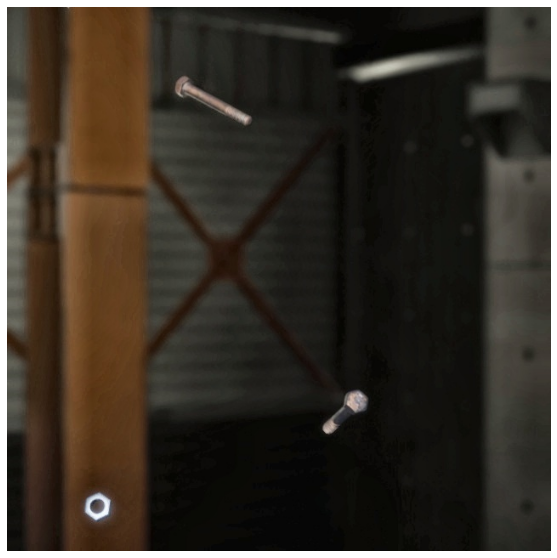

In [9]:
#Sahnenin görüntülenmesi
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(images_list[438])

(array([1.12165e+05, 6.00740e+04, 4.45270e+04, 4.49250e+04, 4.10710e+04,
        4.48370e+04, 3.82760e+04, 1.22520e+04, 5.38600e+03, 2.57000e+03,
        1.15300e+03, 5.53000e+02, 4.41000e+02, 4.69000e+02, 3.11000e+02,
        2.48000e+02, 7.00000e+01, 9.00000e+01, 8.50000e+01, 9.70000e+01]),
 array([  0. ,  12.8,  25.6,  38.4,  51.2,  64. ,  76.8,  89.6, 102.4,
        115.2, 128. , 140.8, 153.6, 166.4, 179.2, 192. , 204.8, 217.6,
        230.4, 243.2, 256. ]),
 <BarContainer object of 20 artists>)

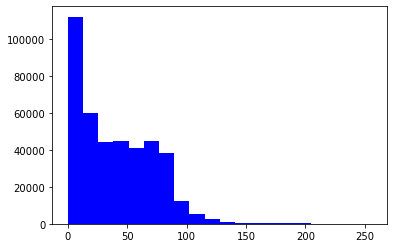

In [10]:
#RGB -> LAB renk aralığında dönüşüm yapılıyor
lab = cv2.cvtColor(preprocess_img.copy(), cv2.COLOR_RGB2LAB)
l,a,b = cv2.split(lab)
#L kanalı ile görüntünün sadece siyah-beyaz olan ve parlaklık değerlerini bulunduran katmanını alıyoruz
#Görüntünün histogram grafiğini yazdırıyoruz
plt.hist(l.flatten(),20,[0,256],color = "b")

Histogram grafiği çok düzensiz olduğu için histogram eşitleme için normal histogram eşitleme yöntemi yerine "Adaptif(Uyarlanabilir) Histogram Eşitleme - CLAHE" yöntemini kullanacağız. Bu yöntemde eşitleme görüntüde bölgesel olarak yapılıp daha iyi sonuçlar alınılabilir.

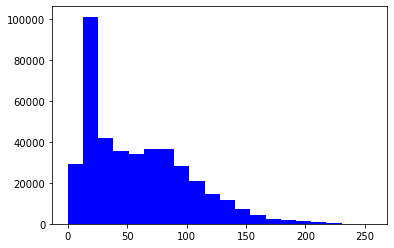

In [11]:
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(16,16))
clh_img = clahe.apply(l)
plt.hist(clh_img.flatten(),20,[0,256],color = "b")
plt.show()

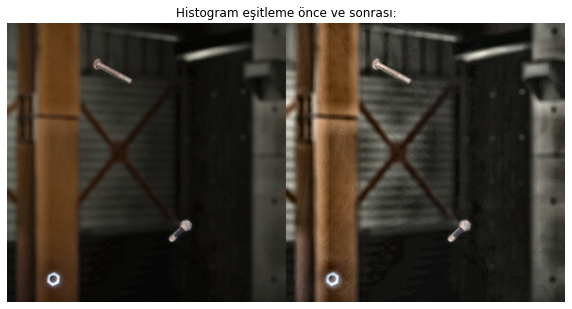

In [12]:
#L kanalı tekrar diğer kanallarla birleştiriliyor
equalized_img = cv2.merge((clh_img,a,b))
equalized_img = cv2.cvtColor(equalized_img, cv2.COLOR_LAB2RGB)
hist_imgs = np.hstack((preprocess_img,equalized_img))

plt.figure(figsize=(10,10))
plt.axis('off')
plt.title("Histogram eşitleme önce ve sonrası:")
plt.imshow(hist_imgs)

Threshold uygulayıp nesne kenarlarını çıkarmak için önce siyah-beyaza dönüşüm ve gauss bulanıklaştırması uygulanır.

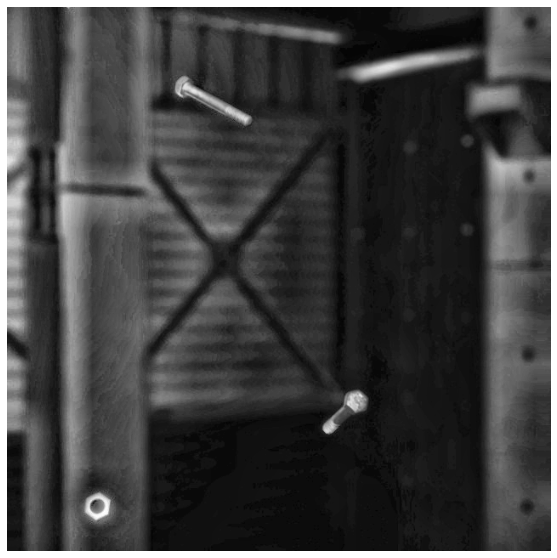

In [13]:
preprocess_img = cv2.cvtColor(equalized_img, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(preprocess_img, cmap='gray')

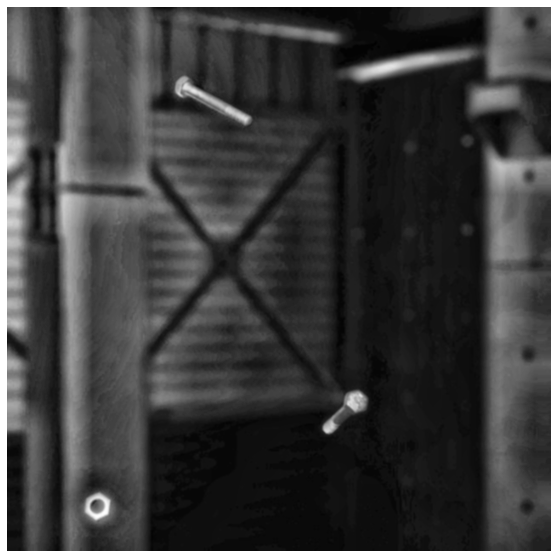

In [14]:
blur = cv2.GaussianBlur(preprocess_img,(3,3),0)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(blur, cmap='gray')

Threshold yöntemleri olarak "Binary Threshold", "Otsu Threshold" ve "Adaptive Threshold" denendi.

Diğer threshold yöntemlerine göre "Adaptive Threshold" değişen parlaklık değerlerine karşı daha iyi sonuç verdiği için bu yöntemi kullandık.

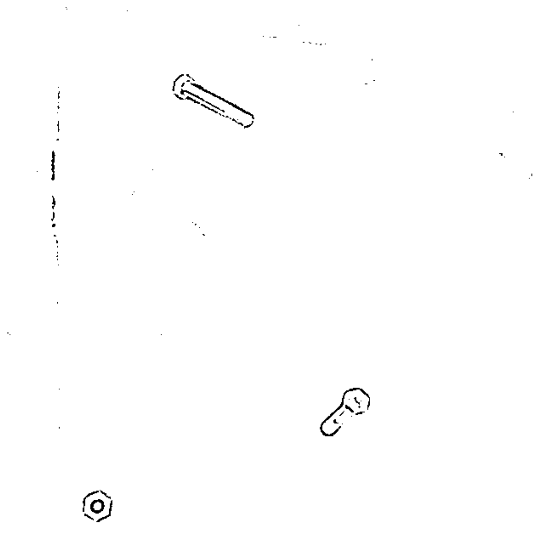

In [15]:
adaptive_th = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,9)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(adaptive_th, cmap='gray')

Görüntüyü basitleştirip nesneleri tespit ettik. Threshold uygulanmamış görüntüler ile modelde eğitimi yapılıp başarı sonuçlarına göre seçim yapılabilir. 

Aşağıda kod ile görüntüler tümüne aynı işlemler uygulanabilir. folder değişkenine uygulanacak klasör yazılabilir. 

Not: İlerleyen eğitimlerde ön işleme aşaması ile daha düşük başarı sonucu verdiği için sadece histogram eşitleme aşamasını kullandık.

In [ ]:
folder = "train"
path = 'C:\\Users\\Asus\\Desktop\\Stroma_Vision\\'
images = os.listdir(path + './dataset/images/{folder}/'.format(folder=folder))

for img in tqdm(images):
    image = cv2.imread('./dataset/images/{folder}/'.format(folder=folder) + img)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(16,16))
    clh_img = clahe.apply(l)
    equalized_img = cv2.merge((clh_img,a,b))
    equalized_img = cv2.cvtColor(equalized_img, cv2.COLOR_LAB2BGR)
    
    #preprocess_img = cv2.cvtColor(equalized_img, cv2.COLOR_RGB2GRAY)
    #blur = cv2.GaussianBlur(preprocess_img,(3,3),0)
    #adaptive_th = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
    #        cv2.THRESH_BINARY,11,9)
    cv2.imwrite('./dataset/images/{folder}/'.format(folder=folder) + img, equalized_img)

## Modelin Eklenmesi

### Yolov8 ile deneme:

Önce Yolov8 ile 10 epochluk eğitimde ön işlemeli ve normal görüntülerin başarısını karşılaştırıyoruz. (Burada Yolov8'i aynı zaman başarısını test etmek için ve hızlı eğittiği için kullandım ancak yeni bir versiyon olduğu ve onnx ile çalıştırma gibi bazı özellikleri desteklemediği için kullanmayacağız.)

In [ ]:
import torch
print(torch.cuda.is_available())

Jupyter notebook'ta (başka yerel ortamlarda kullanılıyor olsa bile) Gpu algılanamayabilir. Eğer Gpu kullanılamıyorsa (False değeri aldıysanız) CUDA versiyonu ile uyumlu kütüphaneleri aşağıdakine benzer olacak şekilde indiriniz. Buradan da uyumlu versiyon bulunabilir: https://pytorch.org/get-started/previous-versions/

In [ ]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip install protobuf==3.20.1

In [ ]:
from ultralytics import YOLO

Eğitim sırasında kernel kapanıyorsa aşağıdaki kod eklenebilir.

In [ ]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Yolo modellerinde data klasörüne eğitim için custom.yaml dosyası ve train.py'ın bulunduğu klasöre hazırladığımız dataset klasörünü ekliyoruz.

Yolov8 için:
```
path: ../ultralytics/ultralytics/dataset/  
train: images/train
val: images/val
test: images/test

# Classes
names:
  0: bolt
  1: nut
```
Yolov7 için:
```
train: ./yolov7/dataset/images/train
val: ./yolov7/dataset/images/val
test: ./yolov7/dataset/images/test

# number of classes
nc: 2

# class names
names: [ 'bolt', 'nut']
```

Eğitim için aşağıdaki kod açılıp dosya yolu düzenlenerek çalıştırılabilir.

```
model = YOLO('yolov8n.pt')
results = model.train(
   data="C:/Users/Asus/Desktop/Stroma_Vision/ultralytics/ultralytics/yolo/data/datasets/custom.yaml",
   imgsz=640,
   epochs=10,
   batch=2,
   name='custom_train'
)
#results = model.val()  # evaluate model performance on the validation set
model = YOLO("runs/detect/custom_train18/weights/best.pt")
model(source="C:/Users/Asus/Desktop/Stroma_Vision/challenge/images/val/val.mp4",show=True,imgsz=640) 
#success = model.export(format="onnx",opset=12)  # export the model to ONNX format
```

#### Sonuçlar:

Ön işlemli eğitim:
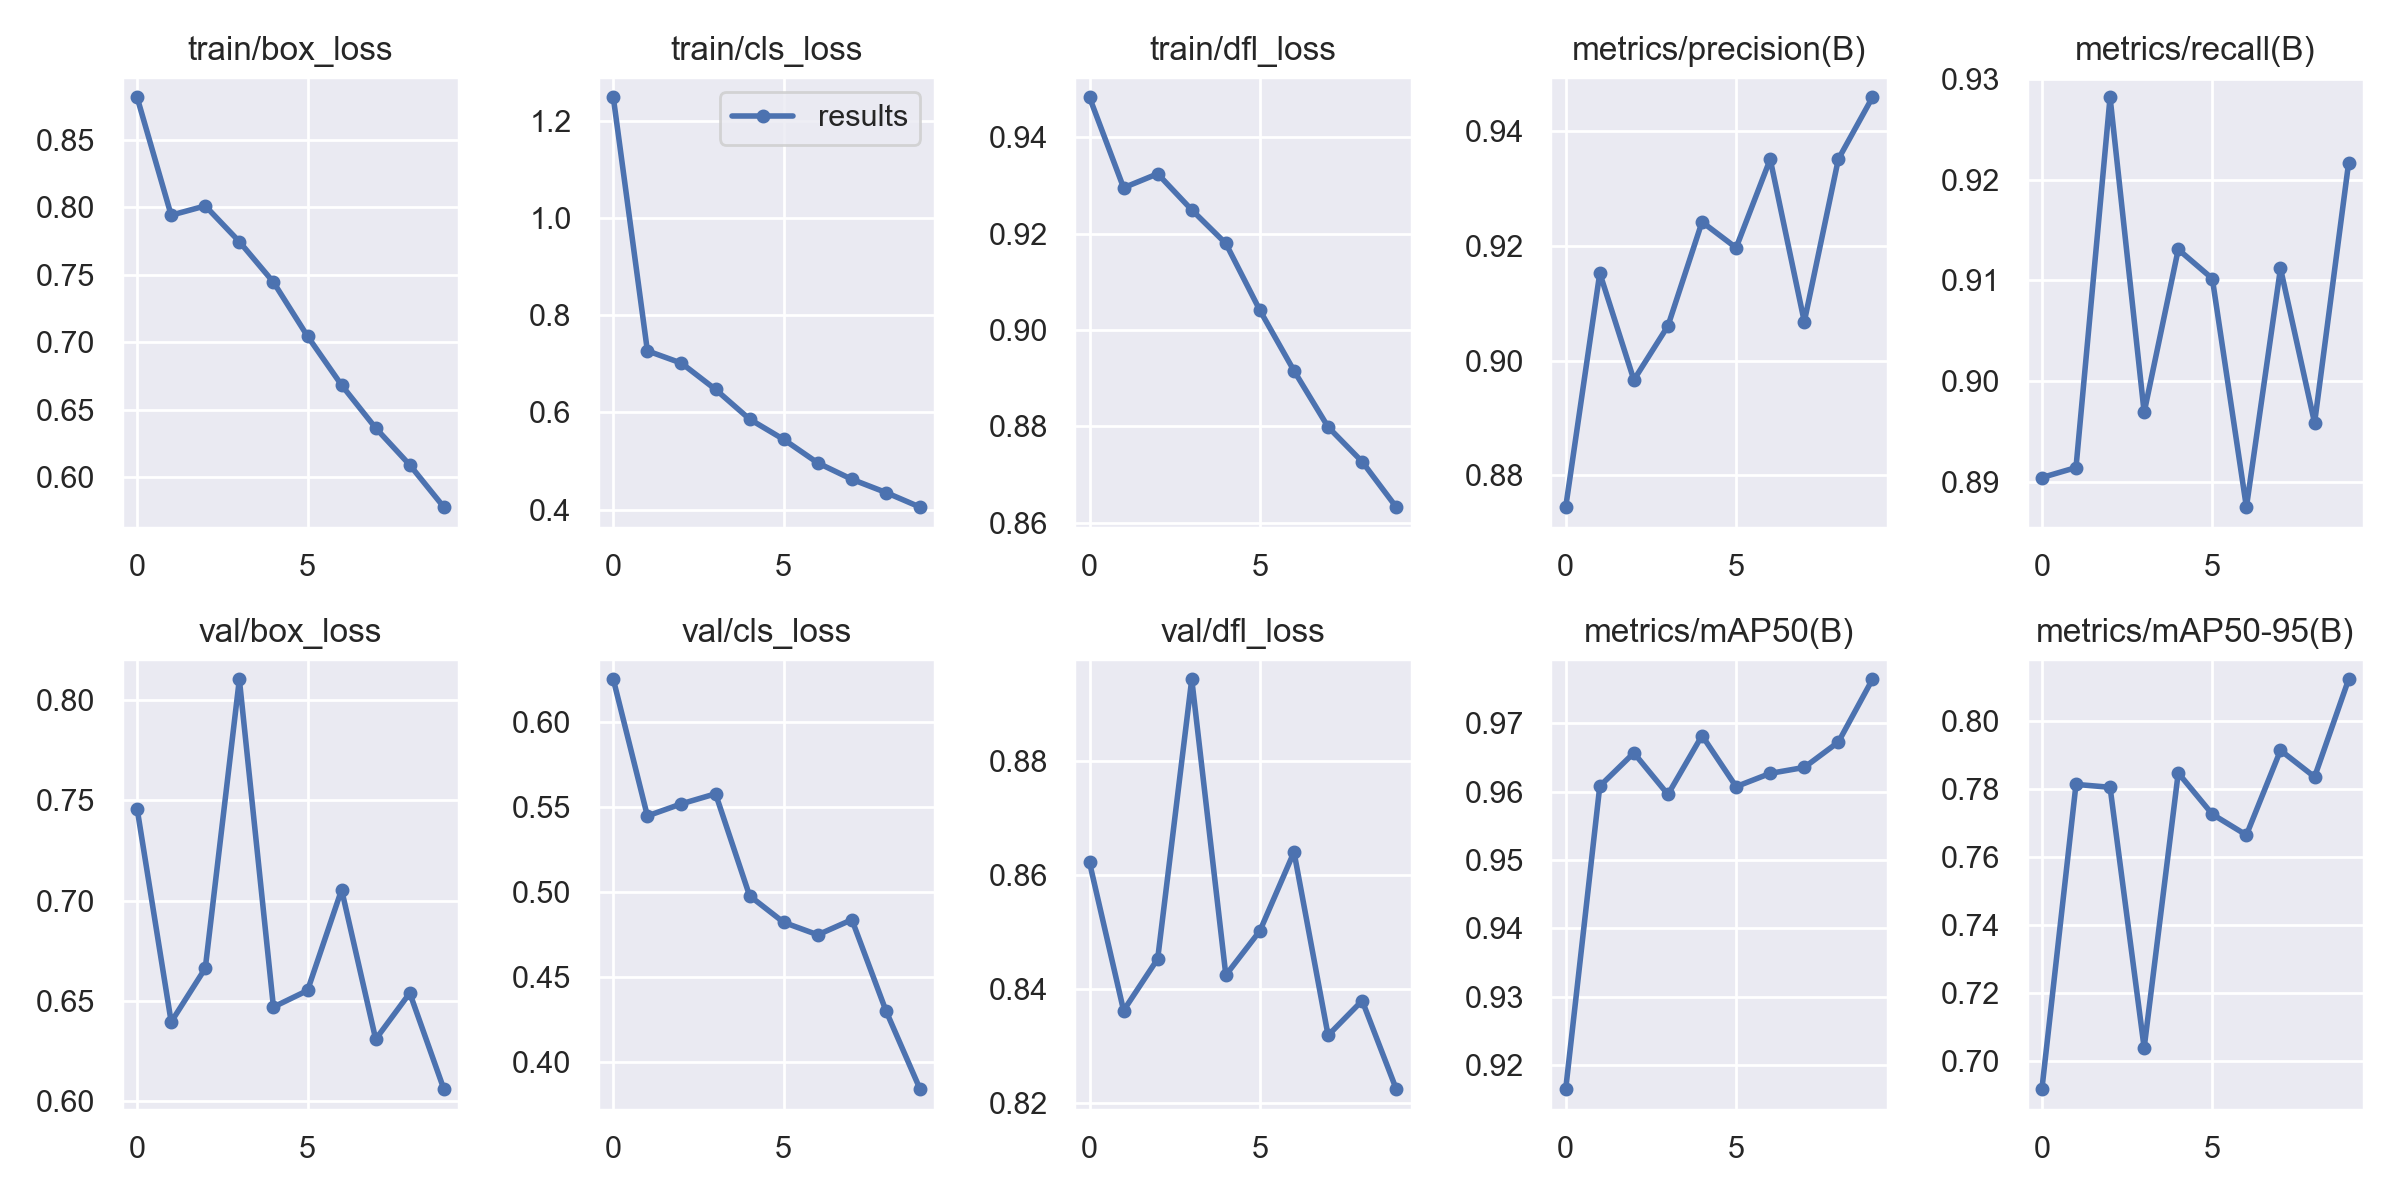

(attachment:custom_train/val_batch1_pred.jpg) 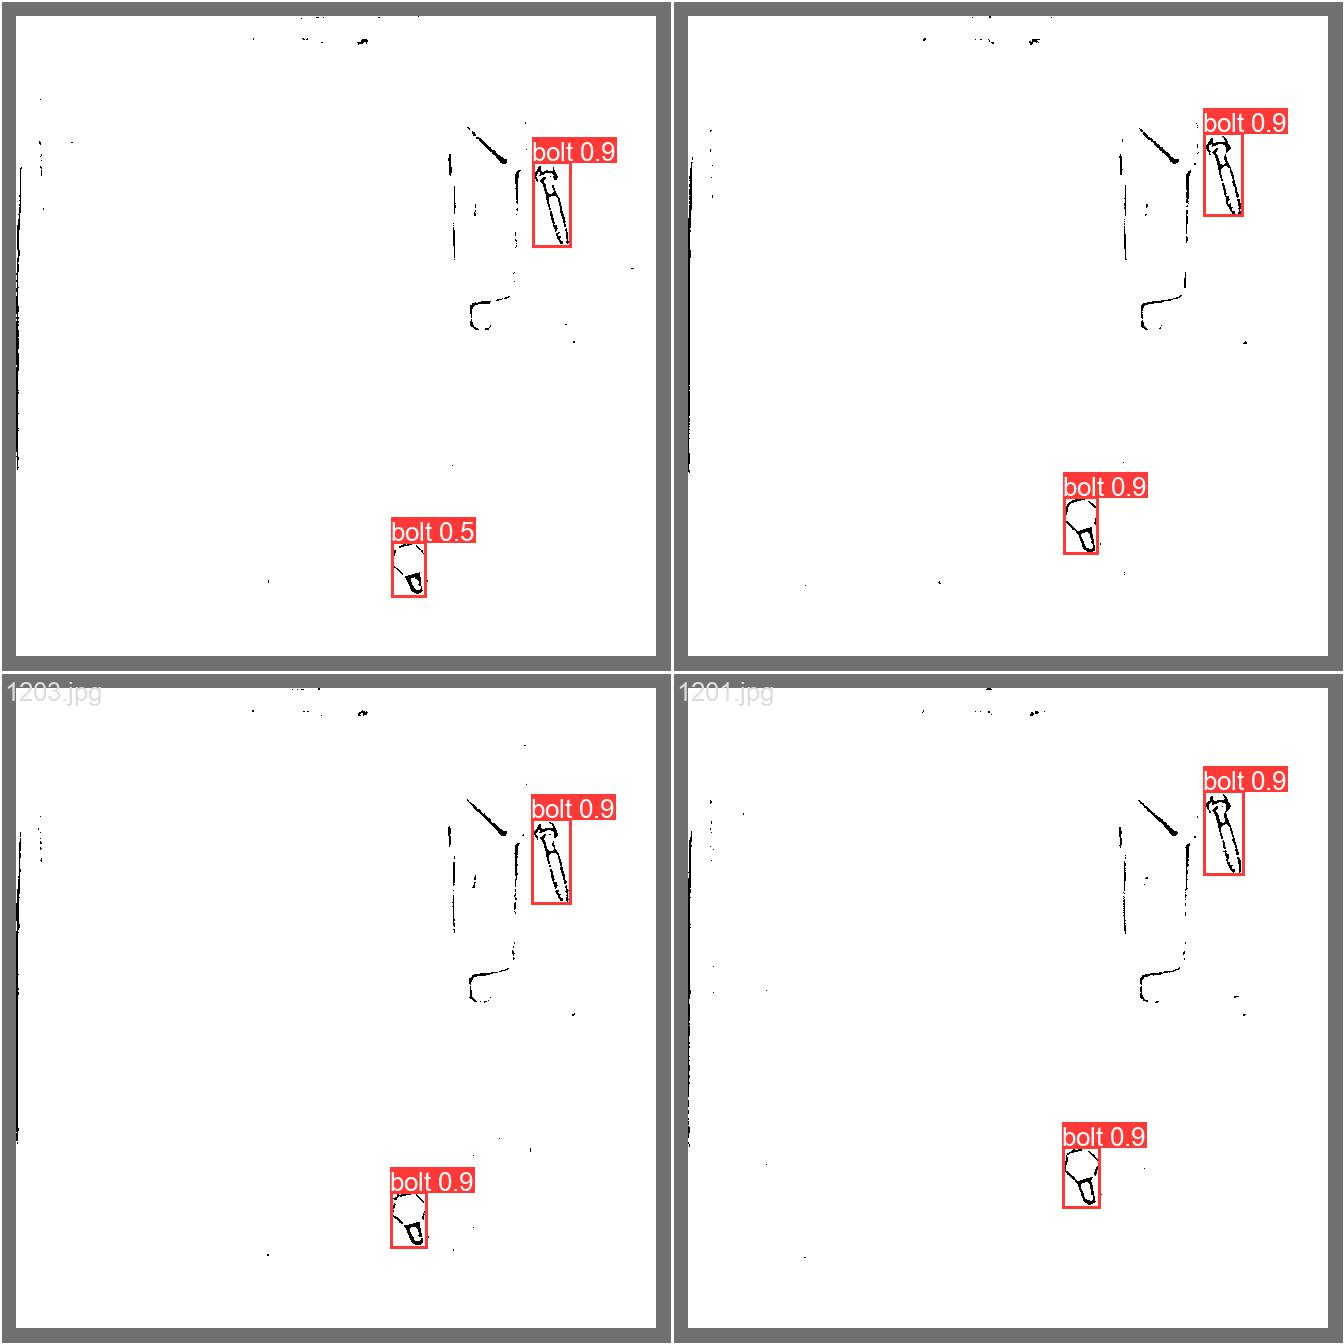

3 kanallı eğitim:
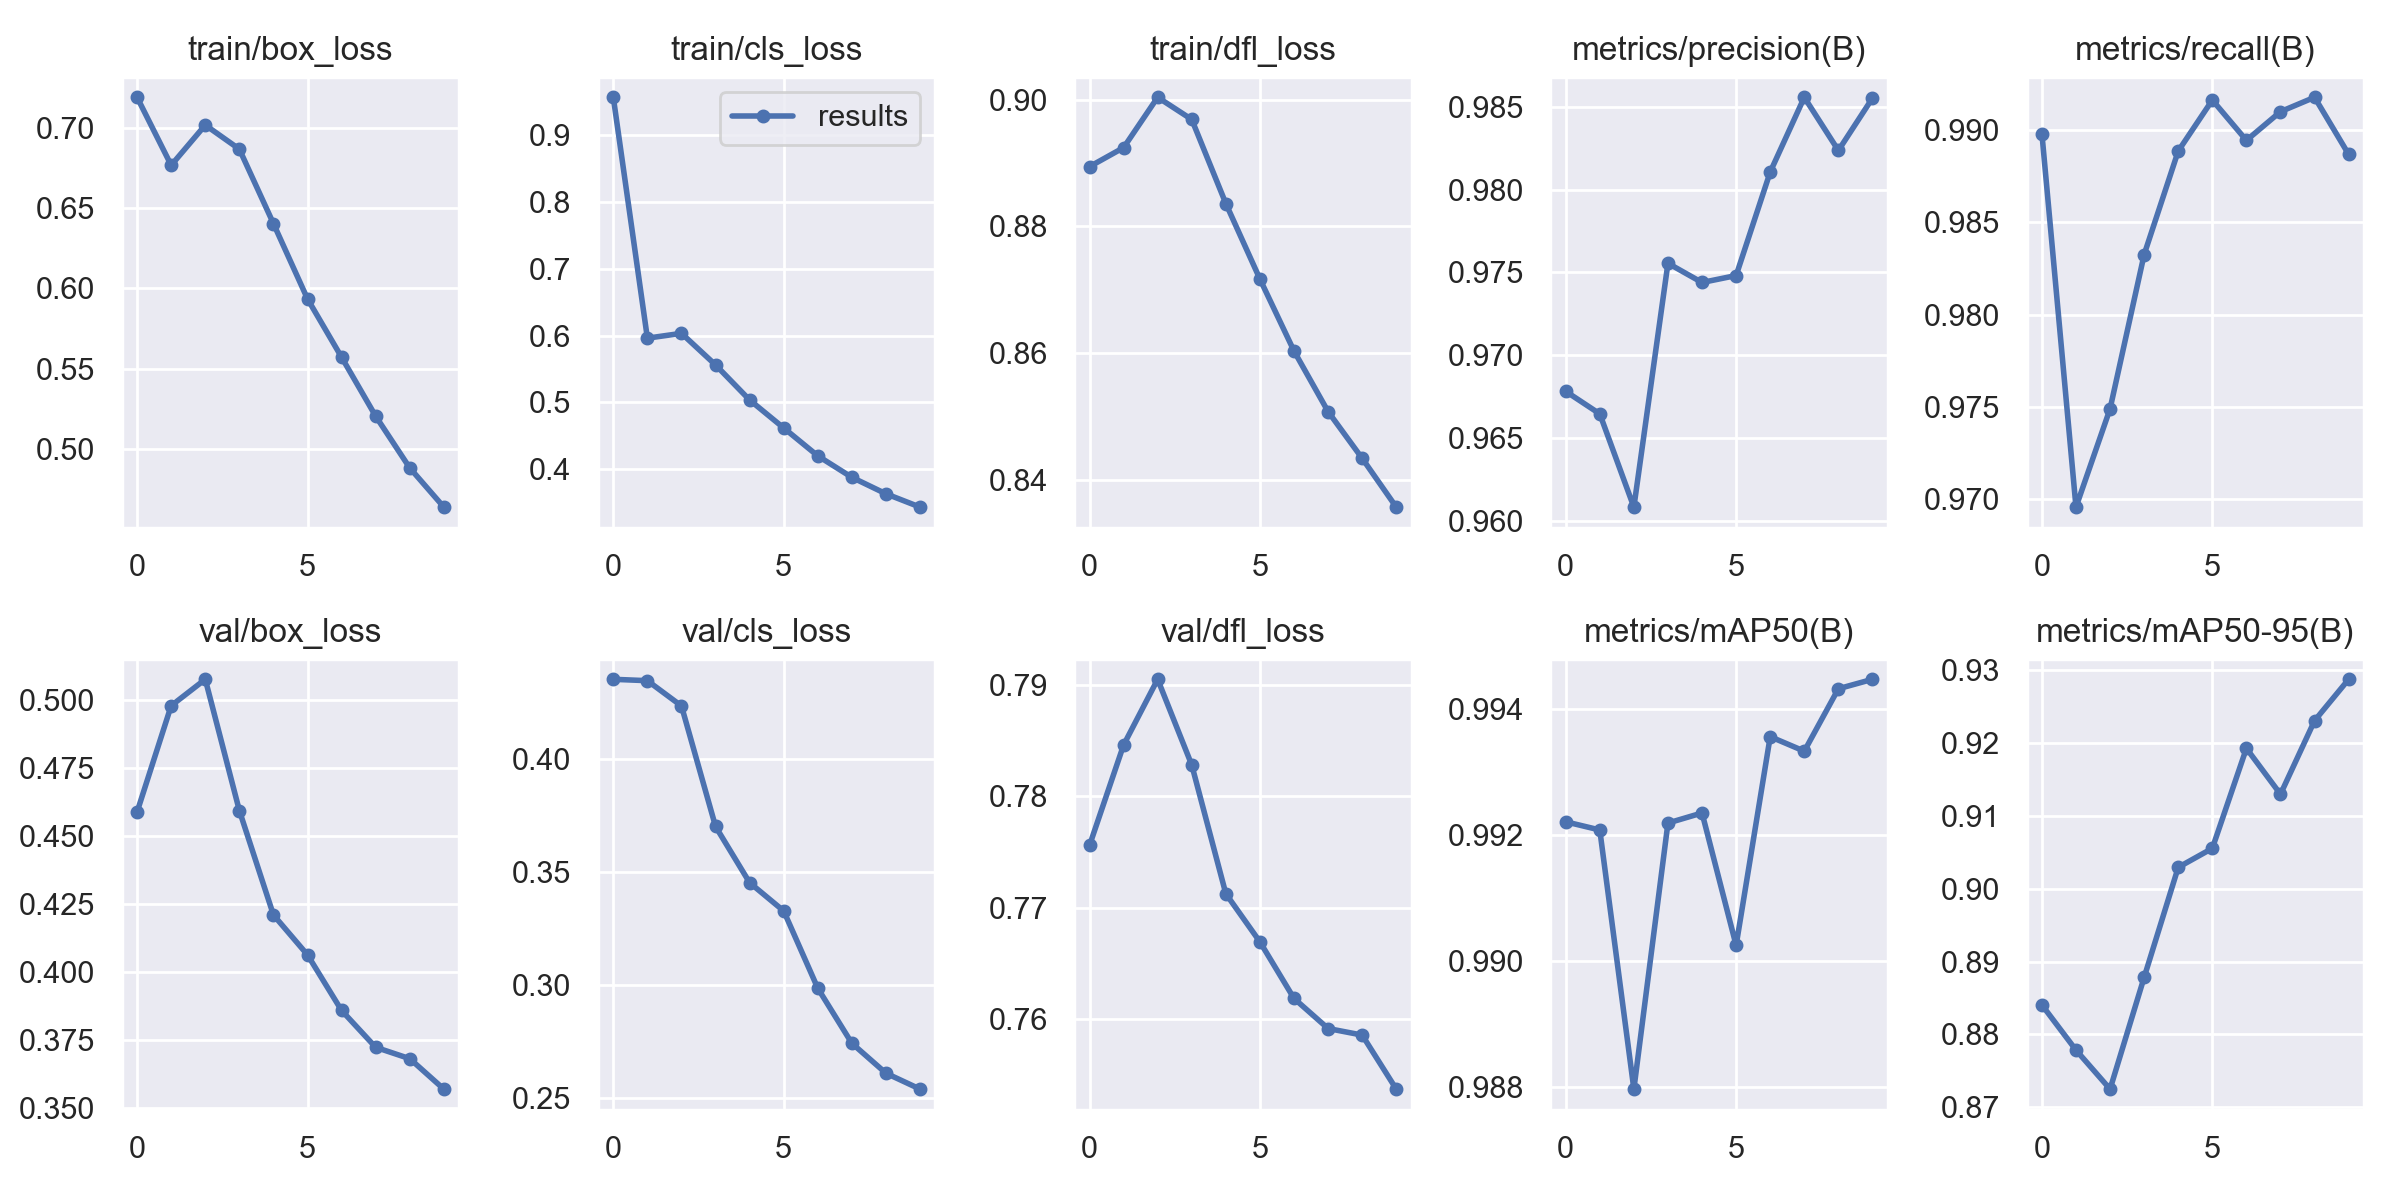

(attachment:custom_train2/val_batch1_pred.jpg) 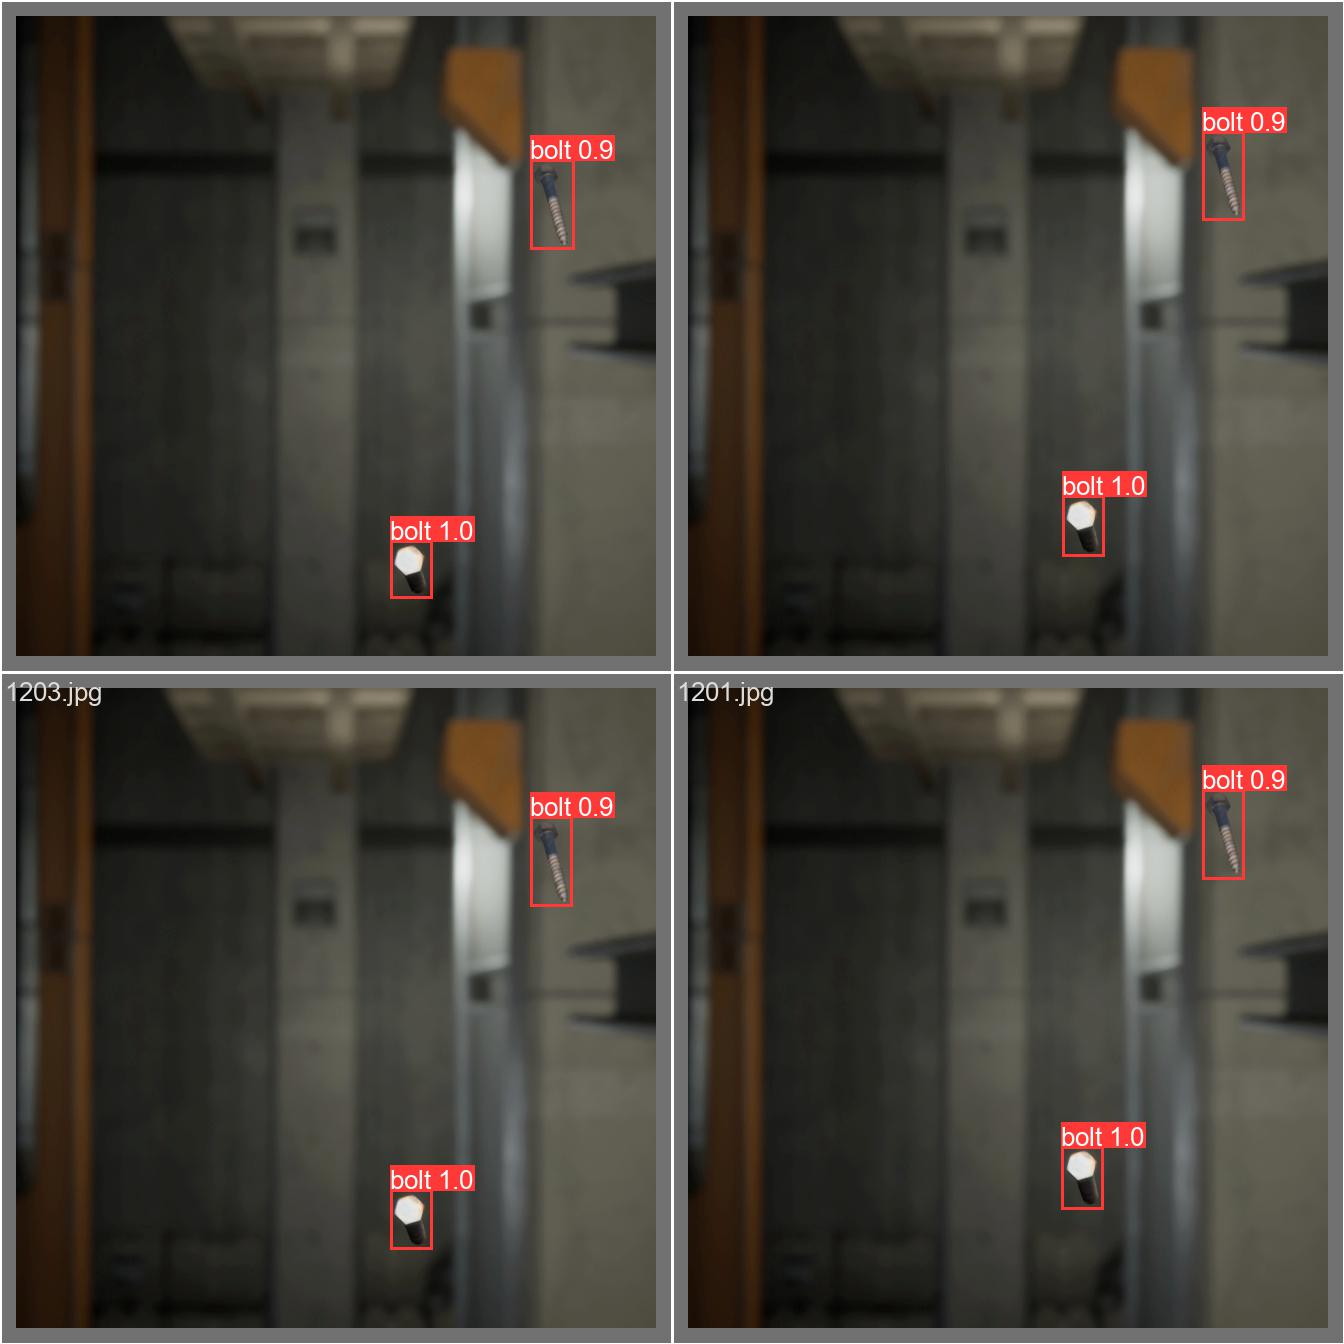

Ön işlemeli verilerle eğitim sonuçları daha düşük çıktığı için sadece histogramı düzenlenmiş veri kümesini kullanacağız.

### Yolov7 ile Eğitim: 

Yolov7 kendi versiyonları içerisinde genel olarak hız ve başarıda iyi bir model. Aynı zamanda Yolo modeli canlı işleme için tercih edilen modeller arasında.

Yukarıda bahsedildiği gibi önce custom.yaml ve dataset klasörünü ekliyoruz. yolov7/cfg/training/yolov7.yaml içerisinde nc değerini iki etiketimiz olduğu için nc: 2 yapıyoruz.

Modelin indirilmesi:

In [ ]:
!git clone https://github.com/WongKinYiu/yolov7.git

Eğitimi parametleri ayarlayıp başlatıyoruz. --image-weights parametresini dengesiz etiket dağılımı için ekliyoruz.
Aynı zamanda yolov7/data/hyp.scratch.custom.yaml içerisinde uygulanacak veri arttırma yöntemleri de bulunmakta.

In [ ]:
!python yolov7/train.py --device 0 --batch-size 2 --data yolov7/data/custom.yaml --img 640 640 --cfg yolov7/cfg/training/yolov7.yaml --weights 'yolov7/yolov7.pt' --name custom_train --hyp yolov7/data/hyp.scratch.custom.yaml --epochs 30 --image-weights

Model eğitiminin Precision,Recall ve mAP sonuçları:

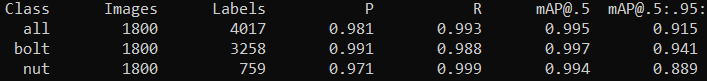

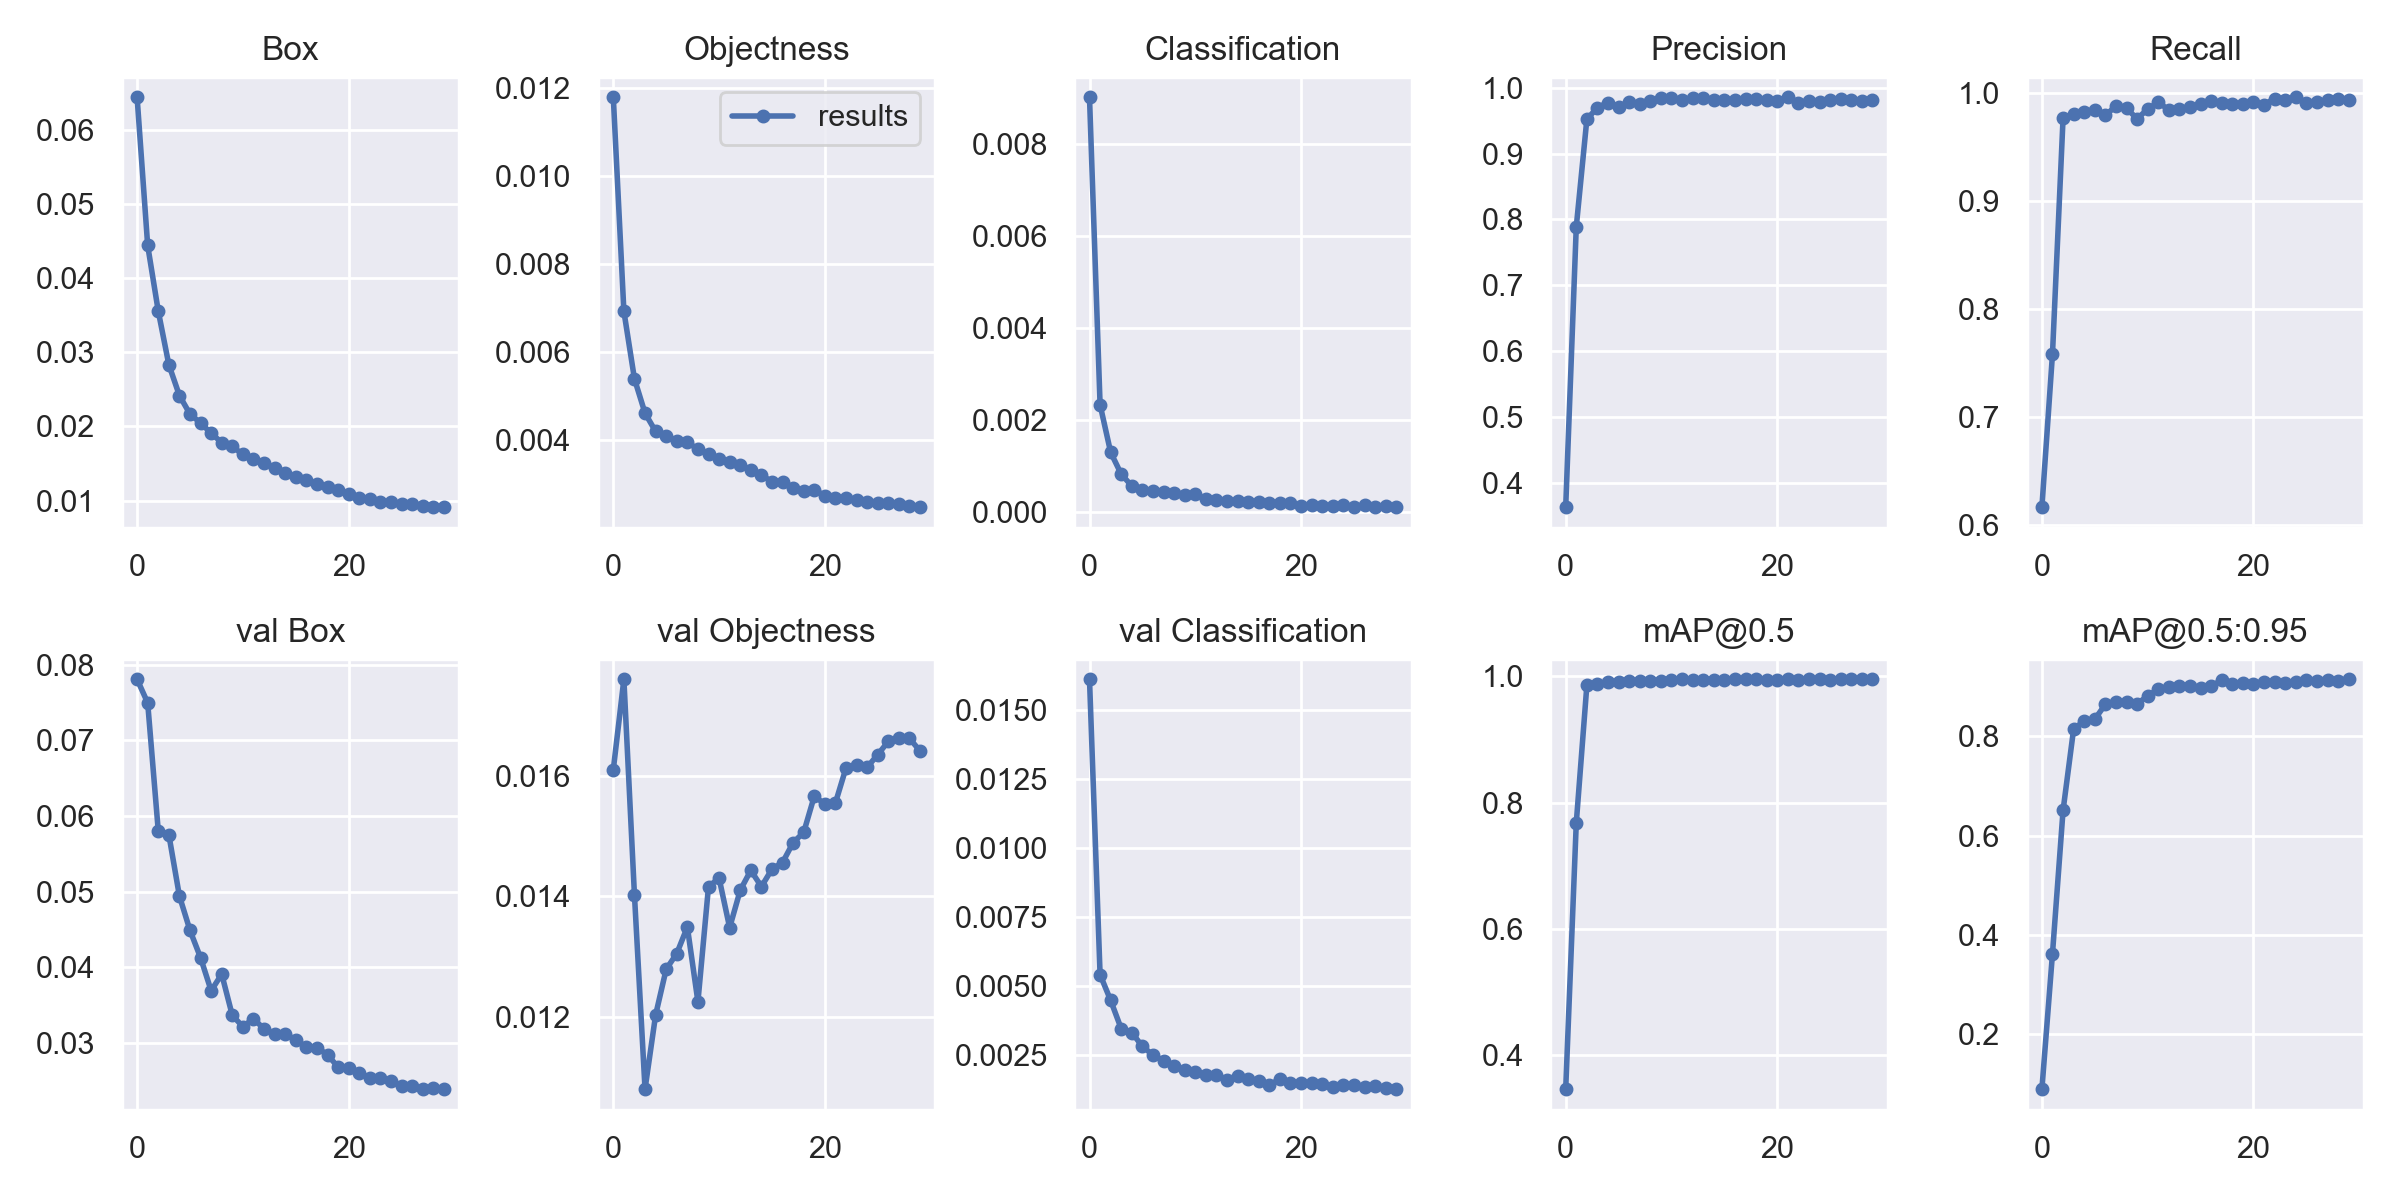

In [ ]:
Elde ettiğimiz ağırlığı export.py ile onnx ve TensorRT kullanarak hızlandıracağız.

In [ ]:
!pip install onnx_graphsurgeon

In [ ]:
!pip install coremltools==4.1

In [ ]:
!python yolov7/export.py --weights ./runs/train/custom_train/weights/best.pt --dynamic 

Uyarı Not: Burada ağırlık budamada (onnx,tensorrt gibi dönüşümlerde) Yolov7 modelinde ve pickle kütüphanesinde sorun çıktığı için Yolo ağırlığında performans karşılaştırması yapamıyoruz. (Takip algoritmasında onnx dönüşümü sağlandı.)

In [ ]:
!python yolov7/detect.py --weights ./runs/train/custom_train/weights/best.onnx --source ./challenge/images/val/val.mp4 --conf-thres 0.85 --iou-thres 0.70 --view-img --device 0 --img 640

### Takip Algoritması(Tracking) Eklenmesi 

In [ ]:
!git clone https://github.com/mikel-brostrom/Yolov7_StrongSORT_OSNet.git

In [ ]:
%cd Yolov7_StrongSORT_OSNet

YOLOv7 ile StrongSort'u aşağıdaki kod ile çalıştırabiliriz. Strong sort ağırlıkları içinden Resnet'i daha hızlı sonuç verdiği için seçtik.

In [ ]:
!python track.py --source val.mp4 --yolo-weights yolov7/best.pt --strong-sort-weights resnet50_fc512_msmt17.pt --img 640 --conf-thres 0.85 --iou-thres 0.70

Video oynatımı(display) olmadan: 24.8ms strong sort yenilenme süresi

In [ ]:
!python track.py --source val.mp4 --yolo-weights yolov7/best.pt --strong-sort-weights resnet50.onnx --img 640 --conf-thres 0.85 --iou-thres 0.70

Video oynatımı(display) olmadan: 17.9ms strong sort yenilenme süresi

**Örnek çıktı videosu** = Stroma_Vision/output.mp4 olarak bulunmaktadır.

### DeepStream İle Çalıştırma

Öncelikle DeepStream ile çalışmak için ortam gerekliliklerini kurunuz ve dosyayı indiriniz. (Notebook başında örnek kurulum versiyonları verilmiştir.) Düzenlemeleri yapılmış konfigürasyon(cfg) dosyaları github dosyalarında verilmiştir.

In [ ]:
!git clone https://github.com/marcoslucianops/DeepStream-Yolo.git

In [ ]:
cd DeepStream-Yolo

```   
Ağırlıkları ve uygun ayarlamaları yapmak için adımlar aşağıda anlatılmıştır:
https://github.com/marcoslucianops/DeepStream-Yolo/blob/master/docs/YOLOv7.md
Parametre bilgileri:
https://docs.nvidia.com/metropolis/deepstream/dev-guide/text/DS_ref_app_deepstream.html
```   

Dönüştürülmüş ağırlık bilgileri config_infer_primary_yoloV7.txt dosyasında verilmiştir:                                    
    ``` 
    custom-network-config=yolov7_best_custom_reparam.cfg
    model-file=yolov7_best_custom_reparam.wts
    num-detected-classes=2
    ``` 

##### deepstream_app_config.txt içerisinde bazı ayarlar:

Dosya çalıştırmak için type 2 ile örnek rtsp linkindeki gibi çalıştırmak için type 4 ile çalıştırınız.
``` 
[source0]
enable=1
#type=4
#uri=rtsp://127.0.0.1:8554/mystream
type=2
uri=file:///home/luna/Desktop/val.mp4
``` 

Bazı hatalarda enable=1 ile fakesink ile çalıştırılabilir. sync=0 daha hızlı, asenkron çalışmasını sağlar.
``` 
[sink0]
width=640
height=640
enable=1
type=2
sync=0
``` 

Videonun döngüsüz çalıştırılması için file-loop=0 yapınız.
``` 
[tests]
file-loop=1
``` 

Not: [tracker] grubu default dosya üzerine eklenmiştir.

!deepstream-app -c deepstream_app_config.txt

Nesne tespiti ve takip algoritmasının Deep Stream ile çalışmasında ortalama 36 FPS alınmaktadır.